In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.table import Table, Column
from itertools import combinations
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.plotting import xy2hist, xy2binned, gridplot
from scipy import stats, odr
np.seterr(invalid='ignore')
plt.rcParams["scatter.edgecolors"] = 'none'

# Partial correlation analysis of the resolved local correlations

In [2]:
bptsel = True

In [3]:
# limit the columns we read to avoid information overload
sspcols   = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols  = ['Name','ix','iy',
             'flux_Halpha_sm','e_flux_Halpha_sm',
             'flux_sigsfr0_sm','e_flux_sigsfr0_sm',
             'flux_sigsfr_corr_sm','e_flux_sigsfr_corr_sm',
             'flux_sigsfr_adopt_sm', 'BPT_sm','p_BPT_sm','SF_BPT_sm']
comomcols = ['Name','ix','iy','mom0_12','e_mom0_12','sigmol','e_sigmol']

# Read the tables
globaltab = EdgeTable('edge_califa.csv', cols=['Name','caMstars','caSFR'])
cofluxtab = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coNomaskDv_smo7','coDilatedDv_smo7'])
try: 
    fluxtab = EdgeTable('edge_carma.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab  = EdgeTable('edge_carma.2d_smo7.hdf5',  path='SSP_sm', cols=sspcols)
    cotab   = EdgeTable('edge_carma.2d_smo7.hdf5',   path='comom_dil', cols=comomcols)
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab  = EdgeTable('NGC4047.2d_smo7.hdf5', path='SSP_sm', cols=sspcols)
    cotab   = EdgeTable('NGC4047.2d_smo7.hdf5', path='comom_smo', cols=comomcols)
    print('Working on NGC 4047 data')

Working on full EDGE database


In [4]:
# consolidate the tables
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
fluxtab.join(globaltab)
# Use the error in extinction-corrected SFR for error in adopted SFR
fluxtab['e_flux_sigsfr_adopt_sm'] = fluxtab['e_flux_sigsfr_corr_sm']
fluxtab['t_dep'] = fluxtab['sigmol'].quantity/fluxtab['flux_sigsfr_adopt_sm'].quantity
fluxtab['f_mol'] = fluxtab['sigmol'].quantity/fluxtab['sigstar_sm'].quantity
fluxtab['ssfr'] = fluxtab['flux_sigsfr_adopt_sm'].quantity/fluxtab['sigstar_sm'].quantity
# Global offset from the main sequence
fluxtab['delSFR'] = fluxtab['caSFR'] - (0.81*fluxtab['caMstars']-8.34)
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'e_flux_Halpha_sm', 'flux_sigsfr0_sm', 'e_flux_sigsfr0_sm', 'flux_sigsfr_corr_sm', 'e_flux_sigsfr_corr_sm', 'flux_sigsfr_adopt_sm', 'BPT_sm', 'p_BPT_sm', 'SF_BPT_sm', 'mass_ssp_sm', 'sigstar_sm', 'mom0_12', 'e_mom0_12', 'sigmol', 'e_sigmol', 'caMstars', 'caSFR', 'e_flux_sigsfr_adopt_sm', 't_dep', 'f_mol', 'ssfr', 'delSFR']


## The `twodet` array indicates pixels detected in CO and H$\alpha$ and for which the Balmer decrement correction could be applied.

In [5]:
# Apply a 3-sigma cut to CO and Halpha
codet = fluxtab['mom0_12'] > 3*fluxtab['e_mom0_12']
hadet = fluxtab['flux_Halpha_sm'] > 3*fluxtab['e_flux_Halpha_sm']
sfdet = hadet & ~np.isnan(fluxtab['flux_sigsfr_adopt_sm'])
twodet = codet & sfdet
print('Valid CO and SFR:', np.count_nonzero(twodet))
if bptsel:
    threedet = codet & sfdet & (fluxtab['sigstar_sm'] > 0) & (fluxtab['SF_BPT_sm'] == 1)
else:
    threedet = codet & sfdet & (fluxtab['sigstar_sm'] > 0)
print('Valid Stars, CO and SFR:', np.count_nonzero(threedet))
sig_mol  = np.log10(fluxtab['sigmol'][threedet])
sig_star = np.log10(fluxtab['sigstar_sm'][threedet])
sig_sfr  = np.log10(fluxtab['flux_sigsfr_adopt_sm'][threedet])
del_ms   = fluxtab['delSFR'][threedet]

Valid CO and SFR: 7042
Valid Stars, CO and SFR: 4651


In [6]:
prop_data = pd.DataFrame({'lg sigstar': sig_star, 'lg sigmol': sig_mol, 'lg sigsfr': sig_sfr})

# get all the pairs of variables
xy_combinations = list(combinations(prop_data.columns, 2))
z = [[col for col in prop_data.columns if col not in xy] for xy in xy_combinations]
xyz_combinations = list(zip(xy_combinations, z))
print(xyz_combinations)

[(('lg sigstar', 'lg sigmol'), ['lg sigsfr']), (('lg sigstar', 'lg sigsfr'), ['lg sigmol']), (('lg sigmol', 'lg sigsfr'), ['lg sigstar'])]


## for OLS regression

lg sigstar lg sigmol ['lg sigsfr'] 0.3556527966467055
lg sigstar lg sigsfr ['lg sigmol'] 0.2508393063154752
lg sigmol lg sigsfr ['lg sigstar'] 0.5215705696522875


level_1,lg sigmol,lg sigsfr,lg sigstar
level_0,,,
lg sigmol,1.000000,0.521571,0.355653
lg sigsfr,0.521571,1.000000,0.250839
lg sigstar,0.355653,0.250839,1.000000


\begin{tabular}{lrrr}
level_1 & lg sigmol & lg sigsfr & lg sigstar \\
level_0 &  &  &  \\
lg sigmol & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 & {\cellcolor[HTML]{73C8BD}} \color[HTML]{000000} 0.521571 & {\cellcolor[HTML]{D9F0B3}} \color[HTML]{000000} 0.355653 \\
lg sigsfr & {\cellcolor[HTML]{73C8BD}} \color[HTML]{000000} 0.521571 & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 & {\cellcolor[HTML]{F6FBC5}} \color[HTML]{000000} 0.250839 \\
lg sigstar & {\cellcolor[HTML]{D9F0B3}} \color[HTML]{000000} 0.355653 & {\cellcolor[HTML]{F6FBC5}} \color[HTML]{000000} 0.250839 & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 \\
\end{tabular}



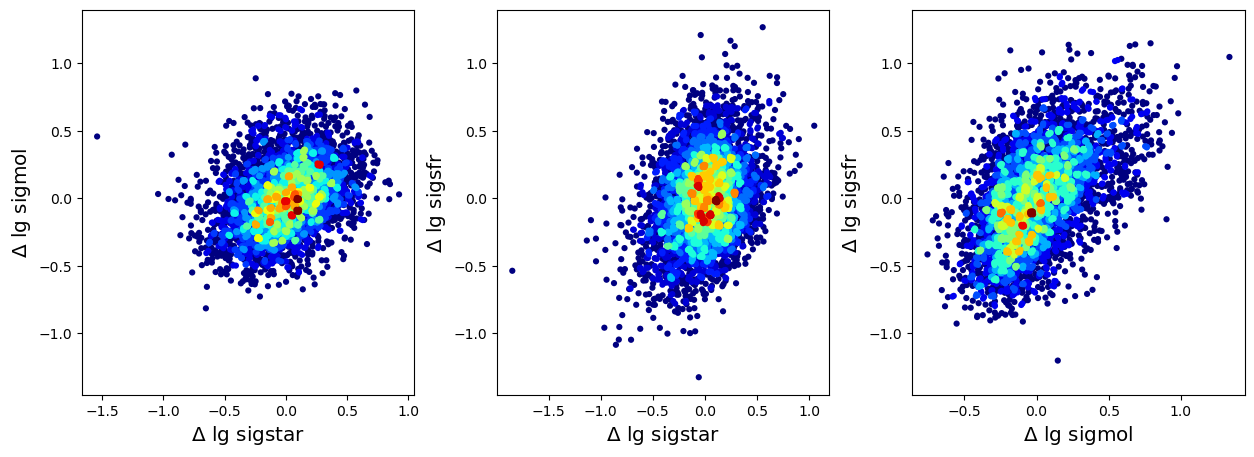

In [7]:
def olsregress(xyz):
    idx, ((var1, var2), var3) = xyz
    var1_reg = linear_model.LinearRegression().fit(prop_data[var3], prop_data[var1])
    var2_reg = linear_model.LinearRegression().fit(prop_data[var3], prop_data[var2])
    var1_res = prop_data[var1] - var1_reg.predict(prop_data[var3])
    var2_res = prop_data[var2] - var2_reg.predict(prop_data[var3])
    new_df = pd.concat([var1_res, var2_res], axis=1)
    xhist, yhist, zhist, *hist = xy2hist(var1_res, var2_res, log=False)
    axs[idx].scatter(xhist, yhist, c=zhist, s=20, cmap='jet')
    axs[idx].set_xlabel('$\Delta$ '+var1, size='x-large')
    axs[idx].set_ylabel('$\Delta$ '+var2, size='x-large')
    axs[idx].tick_params(labelleft=True)
    part_corr_df = new_df.corr(method='spearman')
    print(var1,var2,var3,part_corr_df.values[0][1])
    return part_corr_df.unstack()

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.25)
part_corr_df = pd.DataFrame(pd.concat(list(map(olsregress, enumerate(xyz_combinations)))), 
                            columns=['part_corr']).reset_index()
part_corr_matrix = part_corr_df.pivot_table(values='part_corr', index='level_0', columns='level_1')
# trimask = ~np.tril(np.ones_like(part_corr_matrix, dtype=bool))
# sns.heatmap(part_corr_matrix, cmap='YlGnBu', mask=trimask, annot=True)
s = part_corr_matrix.style.background_gradient(axis=None, cmap="YlGnBu", vmin=0.2, vmax=1)
display(s)
print(s.to_latex(convert_css=True))

## for orthogonal distance regression


Lineregress parameters: 1.65 + x*(0.45+/-0.01)
lg sigstar vs. lg sigsfr: slope 0.643 intercept 1.383

Lineregress parameters: 0.73 + x*(0.53+/-0.01)
lg sigmol vs. lg sigsfr: slope 0.685 intercept 0.515

Lineregress parameters: 1.39 + x*(0.61+/-0.01)
lg sigstar vs. lg sigmol: slope 0.999 intercept 0.810

Lineregress parameters: 0.06 + x*(0.91+/-0.01)
lg sigsfr vs. lg sigmol: slope 1.460 intercept -0.751

Lineregress parameters: 0.09 + x*(0.61+/-0.01)
lg sigmol vs. lg sigstar: slope 1.001 intercept -0.810

Lineregress parameters: -0.36 + x*(0.78+/-0.02)
lg sigsfr vs. lg sigstar: slope 1.556 intercept -2.152


level_1,lg sigmol,lg sigsfr,lg sigstar
level_0,,,
lg sigmol,1.000000,0.629062,0.395086
lg sigsfr,0.629062,1.000000,0.407282
lg sigstar,0.395086,0.407282,1.000000


\begin{tabular}{lrrr}
level_1 & lg sigmol & lg sigsfr & lg sigstar \\
level_0 &  &  &  \\
lg sigmol & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 & {\cellcolor[HTML]{36ABC3}} \color[HTML]{F1F1F1} 0.629062 & {\cellcolor[HTML]{C9EAB4}} \color[HTML]{000000} 0.395086 \\
lg sigsfr & {\cellcolor[HTML]{36ABC3}} \color[HTML]{F1F1F1} 0.629062 & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 & {\cellcolor[HTML]{C2E7B4}} \color[HTML]{000000} 0.407282 \\
lg sigstar & {\cellcolor[HTML]{C9EAB4}} \color[HTML]{000000} 0.395086 & {\cellcolor[HTML]{C2E7B4}} \color[HTML]{000000} 0.407282 & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 \\
\end{tabular}



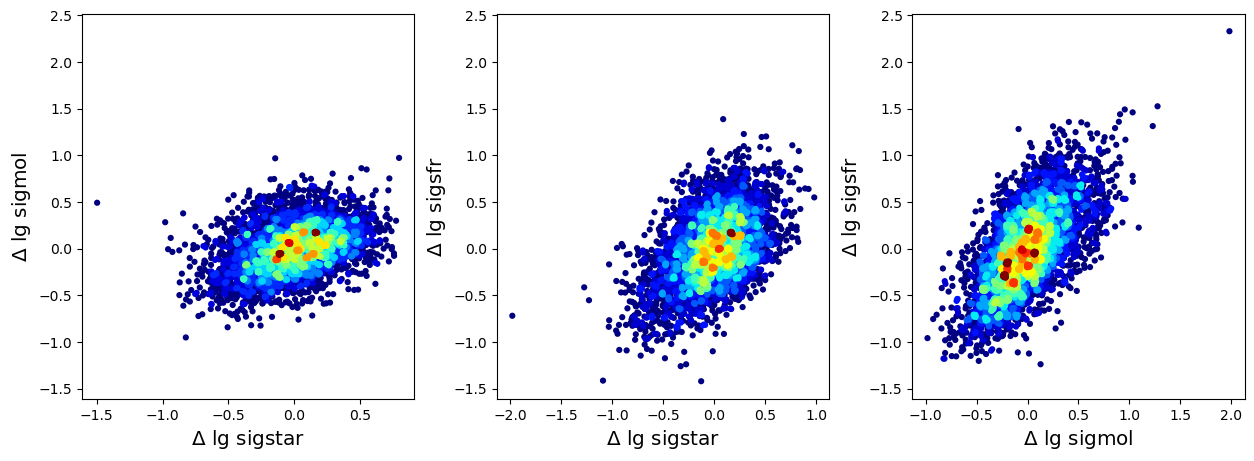

In [8]:
def model(p, x):
    a, b = p
    return a + b*x

def fitODR(x ,y, xerr=None, yerr=None, verbose=False):
    sorted=np.argsort(x)
    xfit = x[sorted]
    yfit = y[sorted]
    if xerr is not None:
        xerrfit = xerr[sorted]
    else:
        xerrfit = None
    if yerr is not None:
        yerrfit = yerr[sorted]
    else:
        yerrfit = None
    b, a, rval, pval, std_err = stats.linregress(xfit, yfit)
    print("\nLineregress parameters: {:.2f} + x*({:.2f}+/-{:.2f})".format(
           a, b, std_err))
    # --- scipy ODR approach
    linear = odr.Model(model)
    mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
    myodr  = odr.ODR(mydata, linear, beta0=[a,b])
    myoutput = myodr.run()
    if verbose:
        print("\n======== Results from scipy.odr =========")
        myoutput.pprint()
    c, d = myoutput.beta
    c_err, d_err = myoutput.sd_beta
    yscat = np.std(yfit-model([c, d], xfit))
    return c, c_err, d, d_err, yscat

def unweighted_odr(xyz):
    idx, ((var1, var2), var3) = xyz
    y0, e_y0, m, e_m, yscat = fitODR(prop_data[var3].values.flatten(), prop_data[var1].values)
    print('{} vs. {}: slope {:.3f} intercept {:.3f}'.format(var1,var3[0],m,y0))
    var1_res = prop_data[var1].values - model([y0, m], prop_data[var3].values.flatten())
    y0, e_y0, m, e_m, yscat = fitODR(prop_data[var3].values.flatten(), prop_data[var2].values)
    print('{} vs. {}: slope {:.3f} intercept {:.3f}'.format(var2,var3[0],m,y0))
    var2_res = prop_data[var2].values - model([y0, m], prop_data[var3].values.flatten())
    xhist, yhist, zhist, *hist = xy2hist(var1_res, var2_res, log=False)
    axs[idx].scatter(xhist, yhist, c=zhist, s=20, cmap='jet')
    axs[idx].set_xlabel('$\Delta$ '+var1, size='x-large')
    axs[idx].set_ylabel('$\Delta$ '+var2, size='x-large')
    axs[idx].tick_params(labelleft=True)
    new_df = pd.concat([pd.Series(var1_res, name=var1), pd.Series(var2_res, name=var2)], axis=1)
    part_corr_df = new_df.corr(method='spearman')
    return part_corr_df.unstack()

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.25)
part_corr_df = pd.DataFrame(pd.concat(list(map(unweighted_odr, enumerate(xyz_combinations)))), 
                            columns=['part_corr']).reset_index()
part_corr_matrix = part_corr_df.pivot_table(values='part_corr', index='level_0', columns='level_1')
s = part_corr_matrix.style.background_gradient(axis=None, cmap="YlGnBu", vmin=0.2, vmax=1)
display(s)
print(s.to_latex(convert_css=True))

## for LEOpy regression

level_1,lg sigmol,lg sigsfr,lg sigstar
level_0,,,
lg sigmol,1.000000,0.506168,0.409529
lg sigsfr,0.506168,1.000000,0.242614
lg sigstar,0.409529,0.242614,1.000000


\begin{tabular}{lrrr}
level_1 & lg sigmol & lg sigsfr & lg sigstar \\
level_0 &  &  &  \\
lg sigmol & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 & {\cellcolor[HTML]{7CCCBB}} \color[HTML]{000000} 0.506168 & {\cellcolor[HTML]{C0E6B5}} \color[HTML]{000000} 0.409529 \\
lg sigsfr & {\cellcolor[HTML]{7CCCBB}} \color[HTML]{000000} 0.506168 & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 & {\cellcolor[HTML]{F8FCC9}} \color[HTML]{000000} 0.242614 \\
lg sigstar & {\cellcolor[HTML]{C0E6B5}} \color[HTML]{000000} 0.409529 & {\cellcolor[HTML]{F8FCC9}} \color[HTML]{000000} 0.242614 & {\cellcolor[HTML]{081D58}} \color[HTML]{F1F1F1} 1.000000 \\
\end{tabular}



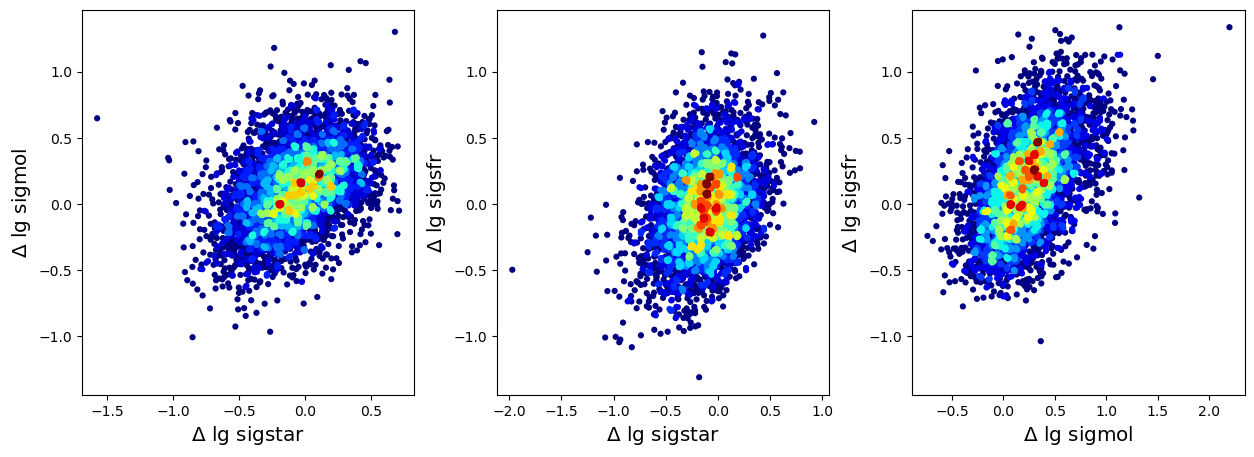

In [9]:
def leopy_fits(xyz):
    idx, ((var1, var2), var3) = xyz
    if var3[0] == 'lg sigsfr':     # x=sfr y=star
        y0, m = 1.51, 0.60
    elif var3[0] == 'lg sigmol':   # x=mol y=star
        y0, m = 1.49, 0.62
    elif var3[0] == 'lg sigstar':  # x=star y=mol
        y0, m = -1.02, 0.99
    var1_res = prop_data[var1].values - model([y0, m], prop_data[var3].values.flatten())
    if var3[0] == 'lg sigsfr':     # x=sfr y=mol
        y0, m = 0.14, 0.87
    elif var3[0] == 'lg sigmol':   # x=mol y=sfr
        y0, m = 0.30, 0.76
    elif var3[0] == 'lg sigstar':  # x=star y=sfr
        y0, m = -0.70, 0.85
    var2_res = prop_data[var2].values - model([y0, m], prop_data[var3].values.flatten())
    xhist, yhist, zhist, *hist = xy2hist(var1_res, var2_res, log=False)
    axs[idx].scatter(xhist, yhist, c=zhist, s=20, cmap='jet')
    axs[idx].set_xlabel('$\Delta$ '+var1, size='x-large')
    axs[idx].set_ylabel('$\Delta$ '+var2, size='x-large')
    axs[idx].tick_params(labelleft=True)
    new_df = pd.concat([pd.Series(var1_res, name=var1), pd.Series(var2_res, name=var2)], axis=1)
    part_corr_df = new_df.corr(method='spearman')
    return part_corr_df.unstack()

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.25)
part_corr_df = pd.DataFrame(pd.concat(list(map(leopy_fits, enumerate(xyz_combinations)))), 
                            columns=['part_corr']).reset_index()
part_corr_matrix = part_corr_df.pivot_table(values='part_corr', index='level_0', columns='level_1')
s = part_corr_matrix.style.background_gradient(axis=None, cmap="YlGnBu", vmin=0.2, vmax=1)
display(s)
print(s.to_latex(convert_css=True))